In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import time

# custom libs
import sys
sys.path.append("..")
from src.simulations import simulate_curves, generate_coeffs
from src.dynamicFPC import K_dFPC, W_dFPC
from src.forecasting import overall_Lnorm

def print_truncated(i, step):
    if i % step == 0:
        print(f"\t {i}")

doc_path = "../../densities4risk_doc/Figures/"

# Sample data

In [5]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
phis = generate_coeffs(d) # AR(1) model coefficients
variance = 1.5

Y, X, mEps = simulate_curves(
                        n,
                        nt,
                        u,
                        phis, 
                        variances=np.full(len(phis), variance)
                        )

In [4]:
T, n = X.shape
x_support = np.arange(T)  

fig = go.Figure()

color_original = "#06d6a0"
color_observed = "#8338ec"

# Unobserved curves (X)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=X[:, j],
            mode="lines",
            line=dict(color=color_original, dash="dash"),
            opacity=0.6,
            showlegend=(j == 0),
            name="Unobserved"
        )
    )

# Observed curves (Y)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=Y[:, j],
            mode="lines",
            line=dict(color=color_observed),
            opacity=0.6,
            showlegend=(j == 0),
            name="Observed"
        )
    )

# Mean curve
fig.add_trace(
    go.Scatter(
        x=x_support,
        y=np.mean(Y, axis=1),
        mode="lines",
        line=dict(color="black", width=3),
        name="Mean(Y)"
    )
)

fig.update_layout(
    title=f"{n} Curves: Original ({color_original}) and Observed ({color_observed})",
    xaxis_title="Index",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()


# Simulations

## Estimating dimensions

In [6]:
# -----------------------
# WdFPC configuration
# -----------------------
WdFPC_kwargs = {
    "wavelet": "db2",
    "N": 3,
    "p": 5,
    "d": d,
    "nt": nt,
}

# -----------------------
# KdFPC configuration
# -----------------------
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": nt,
    "u": u,
    "select_ncomp": False,
    "dimension": d,
}

In [ ]:
# Repetitions
R = 10_000

# Variable
D = 10

timings = {}
for d in range(1, D+1):
    print(f">>>Initiating simulations for d={d}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    phis = generate_coeffs(d)

    for r in range(R):
        print_truncated(r,200)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = d
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = d
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings[d] = df_timing

In [32]:
df = pd.DataFrame()

for k in timings.keys():
    df0 = timings[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [39]:
df.columns = ["WdFPC", "KdFPC", "d"]

In [46]:
print(f"Median of {R:,} simulations for estimating each d of {D} dimensions for {n} curves")
df.groupby("d").median()

Median of 10,000 simulations for estimating each d of 10 dimensions for 100 curves


,WdFPC,KdFPC
d,,
1,0.063722,0.004133
2,0.063787,0.003703
3,0.063029,0.004528
4,0.059256,0.003807
5,0.060620,0.004483
6,0.060661,0.004542
7,0.055070,0.003470
8,0.060443,0.004564
9,0.059066,0.004598


In [35]:
df.to_excel("../data/processed/time_simulation_dim.xlsx", index=False)

## Changing number of curves

In [ ]:
# Repetitions
R = 1_000

# Accuracy measures
norms = ["L1", "L2", "LINF"]

# Variable
N = np.append(
            np.array([100,250]), 
            np.arange(500,3500,500)
            )

D = 4
phis = generate_coeffs(D)
timings_n = {}
accuracy_n = {}
for n in N:
    print(f">>>Initiating simulations for n={n}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    
    wd_accuracy = np.zeros([R,len(norms)])
    kd_accuracy = np.zeros([R,len(norms)])
    
    for r in range(R):
        print_truncated(r,20)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = D
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = D
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

        # ---- Computes L norms ----
        for i, norm in enumerate(norms):
            w_norm = overall_Lnorm(pd.DataFrame(Y), pd.DataFrame(WdFPC_model.Yhat), n_test = Y.shape[1], norm = norm)
            k_norm = overall_Lnorm(pd.DataFrame(Y), pd.DataFrame(KdFPC_model.fitted_values), n_test = Y.shape[1], norm = norm)

            wd_accuracy[r, i] = w_norm
            kd_accuracy[r, i] = k_norm

    # ---- Timing ----
    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings_n[n] = df_timing

    # ---- Accuracy ----
    accuracy_n[n] = {
                    "WdFPC": pd.DataFrame(wd_accuracy, columns=norms),
                    "KdFPC": pd.DataFrame(kd_accuracy, columns=norms)
            }

In [128]:
dfs = []

for n, methods in accuracy_n.items():
    for method, df_ in methods.items():
        tmp = (
            df_
            .assign(n=n, Method=method)
            .reset_index(names="rep")
            .melt(
                id_vars=["n", "Method", "rep"],
                var_name="metric",
                value_name="value"
            )
        )
        dfs.append(tmp)

df_accuracy_long = pd.concat(dfs, ignore_index=True)

In [ ]:
# import json
# import numpy as np

# def dict_to_json_safe(results_dict):
#     out = {}

#     for n, methods in results_dict.items():
#         n = int(n)  # np.int64 → int
#         out[n] = {}

#         for method, df in methods.items():
#             out[n][method] = {
#                 "columns": list(df.columns),
#                 "data": df.to_dict(orient="records")
#             }

#     return out

# json_safe = dict_to_json_safe(accuracy_n)

# with open("../data/processed/time_simulation_accuracy.json", "w") as f:
#     json.dump(json_safe, f, indent=2)

In [ ]:
# Treat accuracy data
# records = []

# for n, methods in accuracy_n.items():
#     for method, df in methods.items():
#         for metric in df.columns:
#             records.append({
#                 "n": int(n),
#                 "method": method,
#                 "metric": metric,
#                 "value": df.loc[0, metric]
#             })

# df_accuracy_long = pd.DataFrame(records).sort_values(by=["n", "metric"])

In [57]:
df = pd.DataFrame()

for k in timings_n.keys():
    df0 = timings_n[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [64]:
df.columns = ["WdFPC", "KdFPC", "n"]
print(f"Median of {R:,} simulations for estimating n of {N} curves with dimension {4}")
df.groupby("n").median()

Median of 1,000 simulations for estimating n of [ 100  250  500 1000 1500 2000 2500 3000] curves with dimension 4


,WdFPC,KdFPC
n,,
100,0.020405,0.002865
250,0.029090,0.019014
500,0.048041,0.082663
1000,0.094255,0.408761
1500,0.151931,1.130965
2000,0.229502,2.589593
2500,0.338074,4.849011
3000,0.457297,8.167511


In [13]:
df_accuracy_comparison = df_accuracy_long.pivot(
    index=["n", "rep", "metric"],
    columns="Method",
    values="value"
    ).reset_index()

In [134]:
df.to_excel("../data/processed/time_simulation_n_2.xlsx", index=False)
df_accuracy_long.to_excel("../data/processed/time_simulation_n_2_accuracy.xlsx", index=False)

In [37]:
# df = pd.read_excel("../data/processed/time_simulation_n_2.xlsx")
# df_accuracy_long = pd.read_excel("../data/processed/time_simulation_n_2_accuracy.xlsx")

<Figure size 1000x500 with 0 Axes>

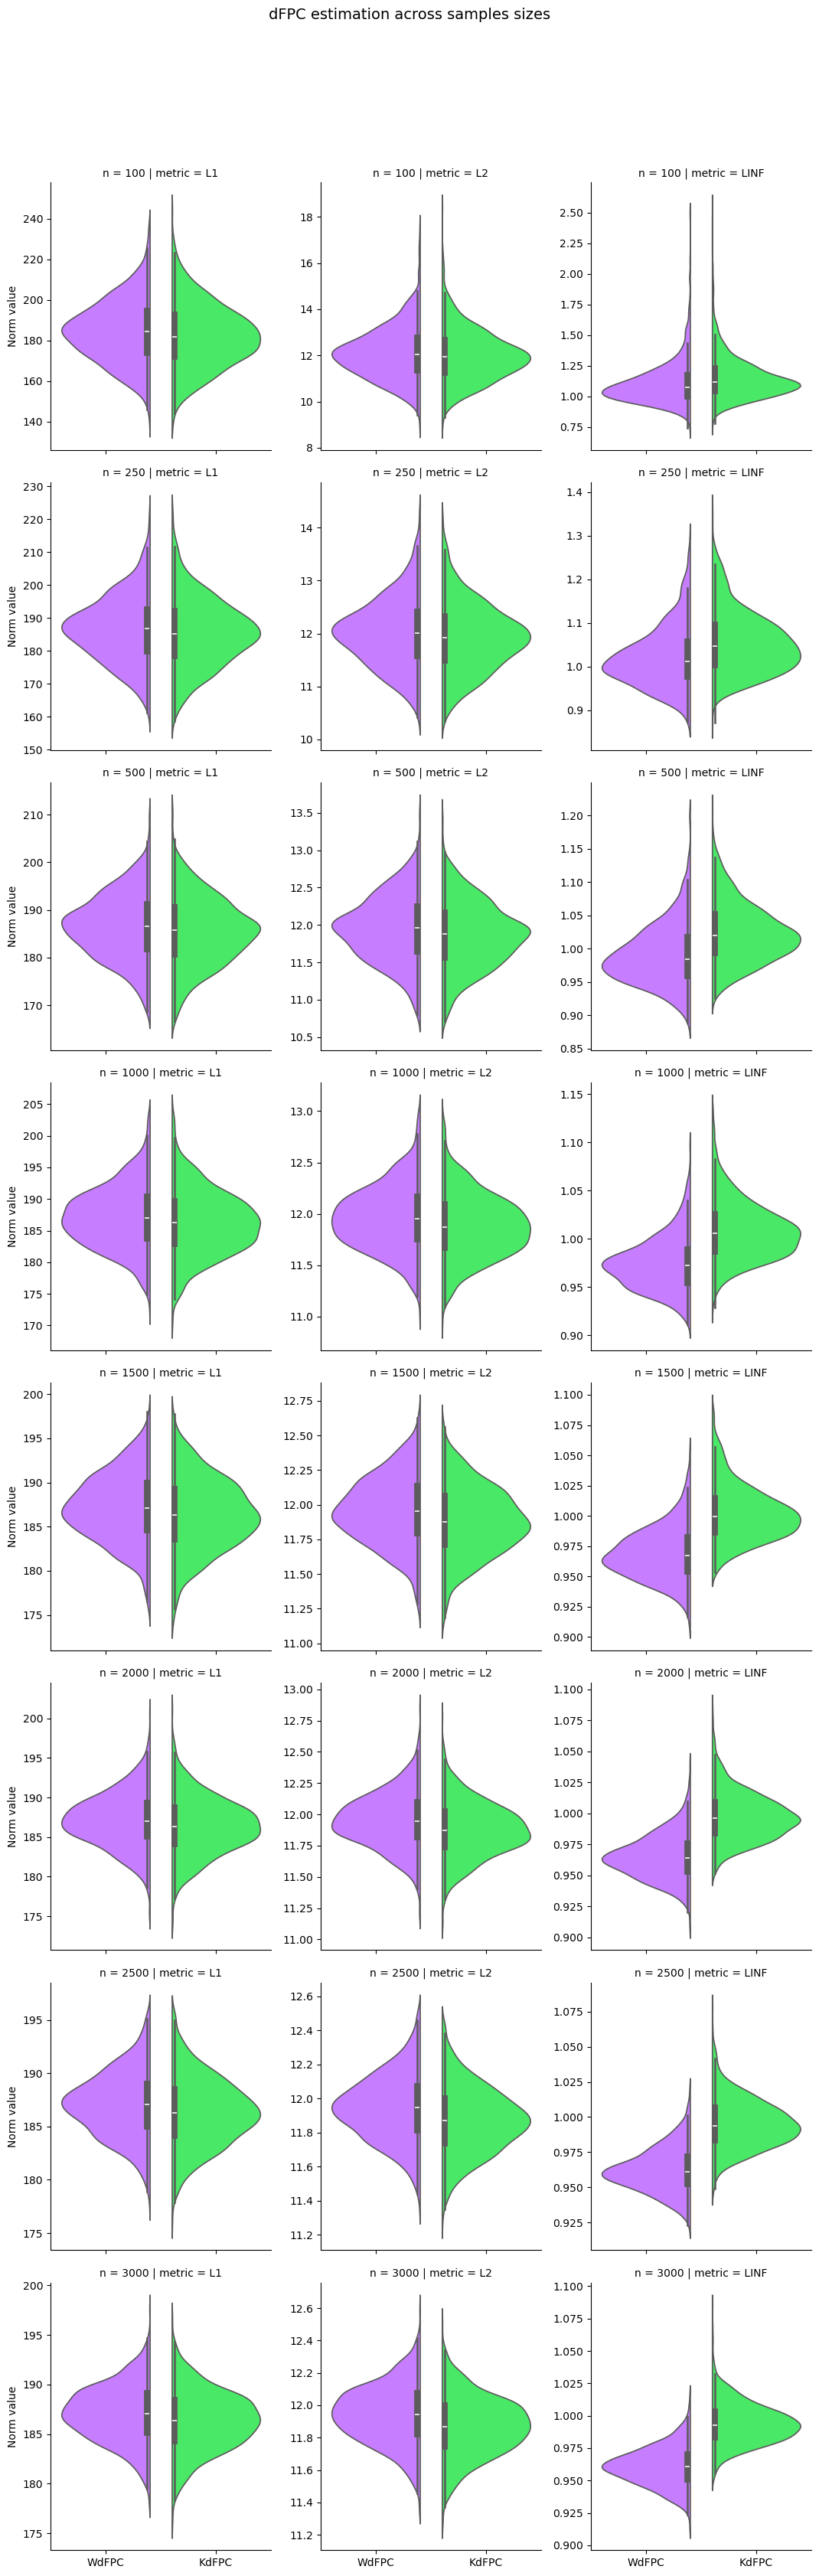

In [30]:
plt.figure(figsize=(10, 5))

g = sns.catplot(
    data=df_accuracy_long,
    x="Method",
    y="value",
    col="metric",
    row="n",
    kind="violin",
    # kind="box",
    hue="Method",
    # kind="violin",
    # inner="quartile",
    # cut=0,
    sharey=False,
    height=4,
    aspect=0.9,
    palette=palette,
    saturation=1,
    split=True
)
for ax in g.axes.flatten():
    ax.set_xlabel("")   # remove "Method"

g.figure.suptitle(
    "dFPC estimation across samples sizes",
    fontsize=14,
    y=1.05
)
g.set_ylabels("Norm value")

plt.tight_layout()

plt.show()

<Figure size 1000x500 with 0 Axes>

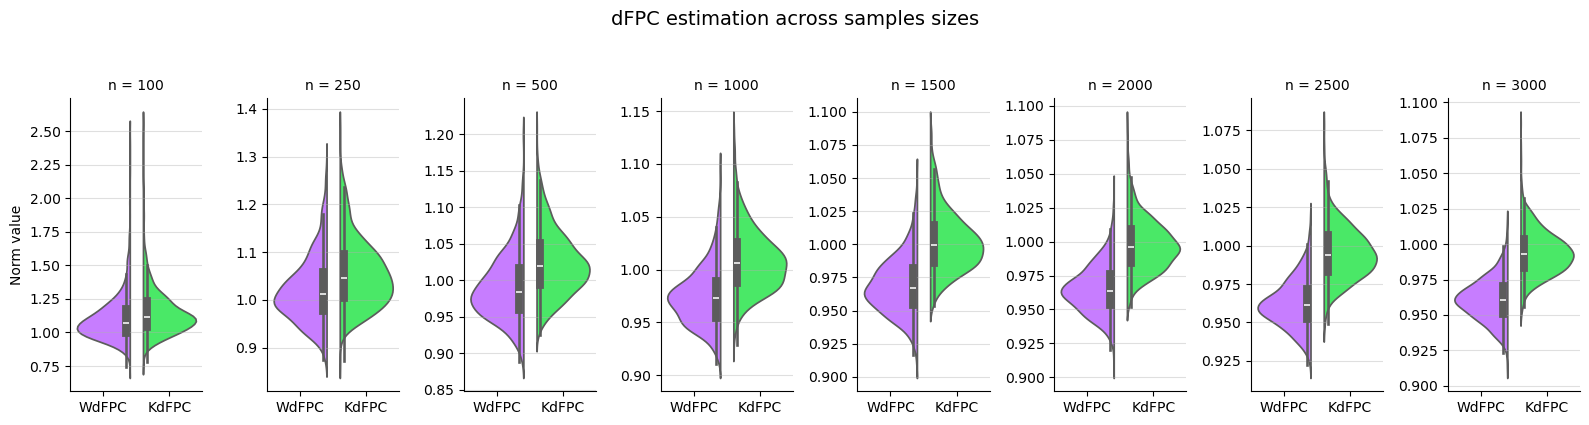

In [ ]:
df_accuracy_long_linf = df_accuracy_long[df_accuracy_long["metric"] == "LINF"]

plt.figure(figsize=(10, 5))

g = sns.catplot(
    data=df_accuracy_long_linf,
    x="Method",
    y="value",
    col="n",
    kind="violin",
    # kind="box",
    hue="Method",
    # kind="violin",
    # inner="quartile",
    # cut=0,
    sharey=False,
    height=4,
    aspect=0.5,
    palette=palette,
    saturation=1,
    split=True
)


for ax in g.axes.flatten():
    ax.set_xlabel("")   # remove "Method"
    ax.grid(True, axis="y", linestyle="-", alpha=0.4)

g.figure.suptitle(
    "dFPC estimation across samples sizes",
    fontsize=14,
    y=1.05
)
g.set_ylabels(f"Norm value")

plt.tight_layout()

plt.savefig(''.join([doc_path, 'sim_n_boxplot_accuracy.png']))

In [65]:
df_long = df.melt(
    id_vars="n",
    value_vars=["WdFPC", "KdFPC"],
    var_name="Method",
    value_name="Time"
)

# make sure n is categorical
df_long["n"] = df_long["n"].astype(str)

In [66]:
palette = {
    # "WdFPC": "#8338ec",
    "WdFPC": "#c77dff",
    "KdFPC": "#4ae867",  
}

<Figure size 1000x500 with 0 Axes>

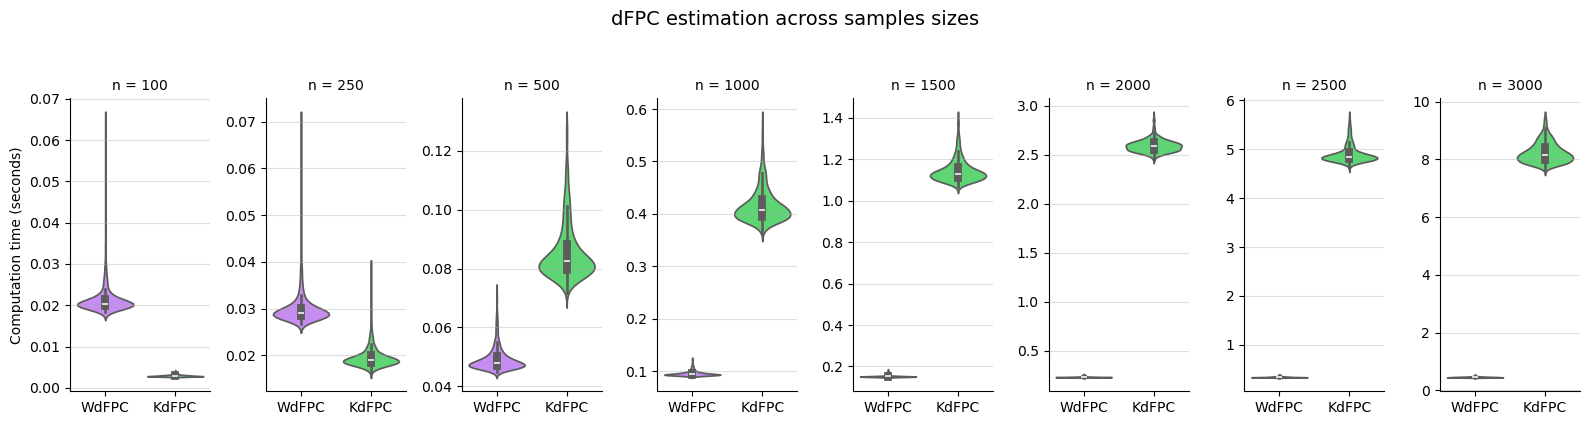

In [ ]:
# retira valores extremos para gráfico de violino/boxplot
df_long_cut = df_long.copy(deep=True)
for i in range(15):
    df_long_cut = df_long_cut.drop(df_long_cut.groupby(["n","Method"])["Time"].idxmax().values)

plt.figure(figsize=(10, 5))

g = sns.catplot(
    data=df_long_cut,
    x="Method",
    y="Time",
    col="n",
    kind="violin",
    # kind="box",
    hue="Method",
    # kind="violin",
    # inner="quartile",
    # cut=0,
    sharey=False,
    height=4,
    aspect=0.5,
    palette=palette
)
for ax in g.axes.flatten():
    ax.set_xlabel("")   # remove "Method"

g.figure.suptitle(
    "dFPC estimation across samples sizes",
    fontsize=14,
    y=1.05
)
g.set_ylabels("Computation time (seconds)")

for ax in g.axes.flatten():
    ax.grid(True, axis="y", linestyle="-", alpha=0.4)

plt.tight_layout()
plt.savefig(''.join([doc_path, 'sim_n_boxplot.png']))

C:\Users\user\AppData\Local\Temp\ipykernel_19264\285905018.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


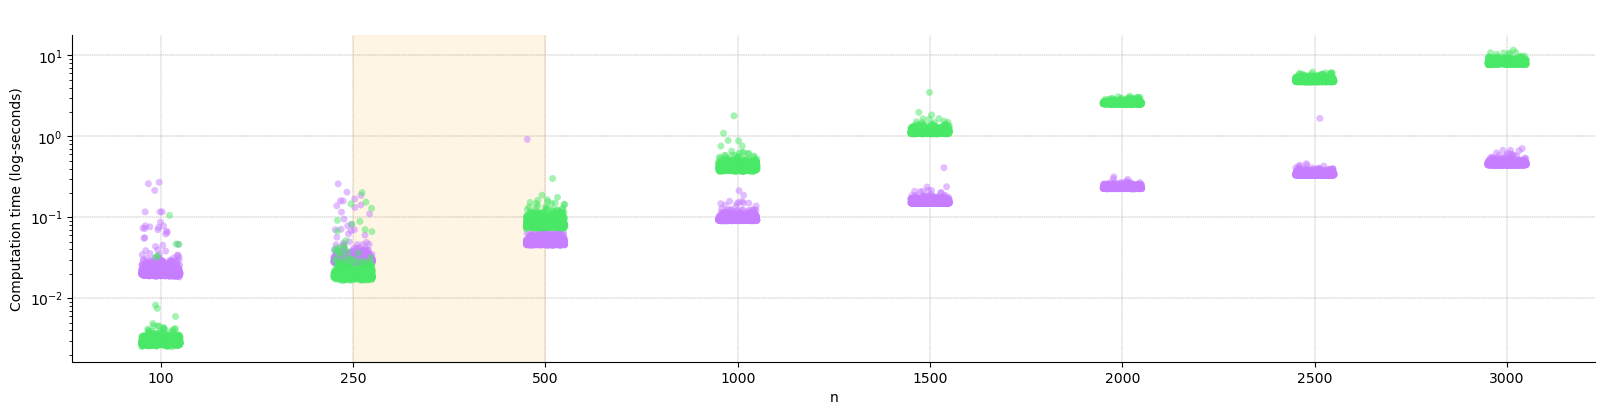

In [47]:
g = sns.catplot(
    data=df_long,
    x="n",
    y="Time",
    hue="Method",
    height=4,
    aspect=4,
    palette=palette,
    legend=False,
    alpha=0.5
)

# g.figure.suptitle(
#     "dFPC estimation across samples sizes",
#     fontsize=14,
#     y=1.05
# )
g.set_ylabels("Computation time (log-seconds)")


for ax in g.axes.flat:
    ax.axvspan(
        1, 2,
        color="orange",
        alpha=0.1,
        zorder=0
    )

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    frameon=False,
    title=None
)

plt.yscale("log")
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.savefig(''.join([doc_path, 'sim_n_scatter.png']))